In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import datetime
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')

!wget https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv -O /tmp/stats.csv
reg = pandas.read_csv('/tmp/stats.csv')
reg = reg[reg['cluster'] == 'dahu']
reg['start_time'] = pandas.to_datetime(reg['start_time'], unit='s')
reg['cpu_id'] = reg['node']*len(reg['cpu'].unique()) + reg['cpu'] - 2
reg.head()

--2019-10-29 14:24:28--  https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv
Résolution de gitlab.in2p3.fr (gitlab.in2p3.fr)… 134.158.69.41
Connexion à gitlab.in2p3.fr (gitlab.in2p3.fr)|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 8713490 (8,3M) [text/plain]
Sauvegarde en : « /tmp/stats.csv »

/tmp/stats.csv      100%[===================>]   8,31M  13,7MB/s    ds 0,6s    

2019-10-29 14:24:29 (13,7 MB/s) — « /tmp/stats.csv » sauvegardé [8713490/8713490]



,function,cluster,node,cpu,jobid,start_time,expfile_hash,avg_gflops,intercept,intercept_residual,...,nk_residual,tvalue_mk,tvalue_mk_residual,tvalue_mn,tvalue_mn_residual,tvalue_mnk,tvalue_mnk_residual,tvalue_nk,tvalue_nk_residual,cpu_id
0,dgemm,dahu,8,0,1870101,2019-06-14 21:28:39,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,28.877805,0.000002,2.437149e-07,...,4.469348e-11,55.454129,2.913950,6.170057,1.578953,812.881583,26.899838,89.470963,7.159150,14
1,dgemm,dahu,8,1,1870101,2019-06-14 21:28:39,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.855755,0.000002,3.921434e-07,...,3.148164e-11,65.527023,15.986252,7.008951,5.175509,990.987085,21.848064,114.435233,19.119759,15
2,dgemm,dahu,9,0,1870102,2019-06-14 21:28:45,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.805097,0.000002,1.956603e-07,...,2.996340e-11,65.816084,11.683131,7.258983,4.056722,999.873755,30.574336,114.988085,14.322827,16
3,dgemm,dahu,9,1,1870102,2019-06-14 21:28:45,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.815750,0.000002,5.322692e-07,...,3.168267e-11,65.322986,14.608848,7.098248,4.323275,997.488581,22.661521,114.954386,17.596415,17
4,dgemm,dahu,1,0,1870094,2019-06-14 21:30:06,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,27.760311,0.000002,3.734852e-07,...,4.443506e-11,59.809588,2.073633,6.192997,2.100520,913.573471,21.679467,100.117176,6.674402,0


There has been some evolutions in the data collected (in both the calibration method and the nodes themselves). Let's restrict ourselves to the desired timeframe. The following plot should not exhibit any temporal pattern.

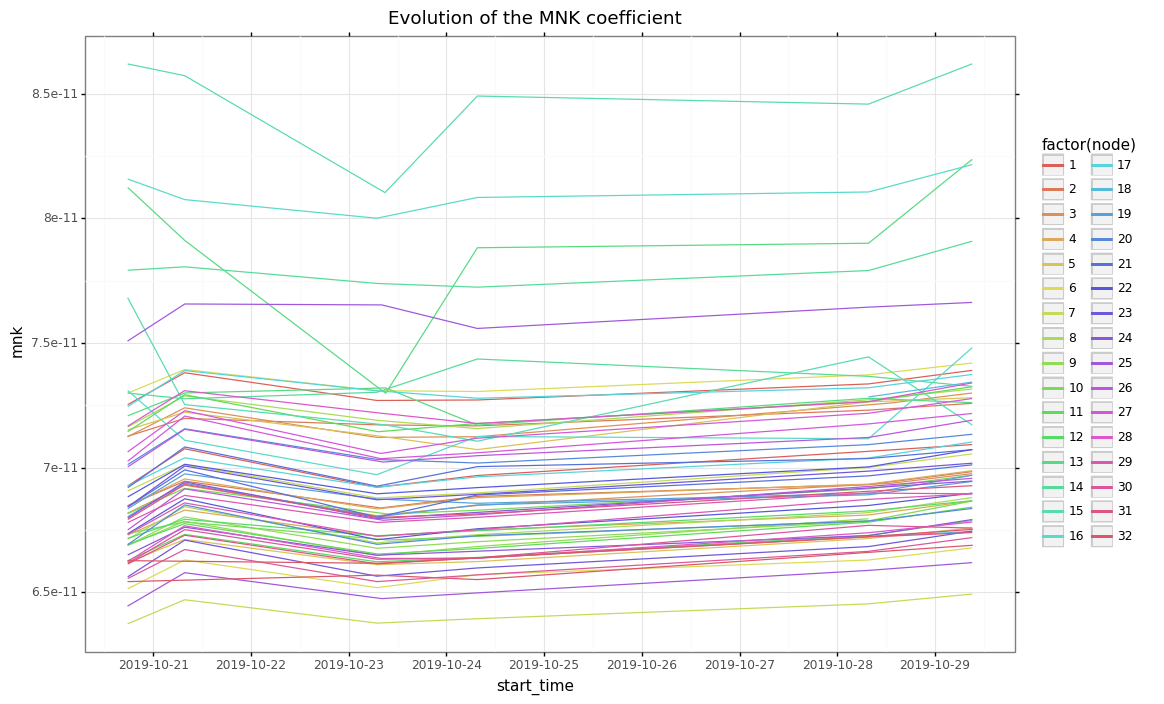

<ggplot: (-9223363260344637973)>

In [2]:
start = pandas.to_datetime('2019-10-19', format='%Y-%m-%d')
reg = reg[reg['start_time'] >= start]
ggplot(reg, aes(x='start_time', y='mnk', group='cpu_id', color='factor(node)')) + geom_line() + theme_bw() + ggtitle('Evolution of the MNK coefficient')

In [3]:
reg = reg.groupby(['node', 'cpu']).mean().reset_index()
reg.head()

,node,cpu,jobid,avg_gflops,intercept,intercept_residual,mk,mk_residual,mn,mn_residual,...,nk_residual,tvalue_mk,tvalue_mk_residual,tvalue_mn,tvalue_mn_residual,tvalue_mnk,tvalue_mnk_residual,tvalue_nk,tvalue_nk_residual,cpu_id
0,1,0,1.890155e+06,25.630254,0.000003,3.942041e-07,2.319514e-09,2.363765e-11,-1.443585e-10,3.785636e-11,...,6.172746e-11,46.398283,1.800476,-1.307262,2.928484,671.465821,22.319648,64.497204,4.907679,0.0
1,1,1,1.890155e+06,26.785852,0.000003,5.097946e-07,2.281112e-09,2.101547e-11,-2.210295e-10,2.172955e-11,...,1.759677e-11,37.996846,1.113856,-1.945146,1.329755,531.783811,24.415975,51.033547,1.398788,1.0
2,2,0,1.890156e+06,26.040114,0.000003,3.609668e-07,2.332165e-09,2.844224e-11,-1.452183e-10,2.055670e-11,...,5.346529e-11,45.874265,2.310776,-1.123725,1.726941,647.889689,20.540971,63.840530,4.567833,2.0
3,2,1,1.890156e+06,27.068351,0.000003,4.539582e-07,2.274483e-09,2.802920e-11,-1.421251e-10,2.416444e-11,...,4.400807e-11,46.841799,2.500243,-1.390380,2.150953,651.332948,23.003644,66.534077,4.235077,3.0
4,3,0,1.890158e+06,26.102832,0.000003,3.870118e-07,2.285577e-09,1.395972e-11,-1.654071e-10,4.113603e-11,...,5.909440e-11,39.519110,0.702594,-1.389469,2.403898,568.063599,21.080735,53.306900,3.624576,4.0


In [4]:
reg[['mnk', 'mn', 'mk', 'nk', 'intercept', 'mnk_residual']].describe()

,mnk,mn,mk,nk,intercept,mnk_residual
count,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01
mean,7.002694e-11,-1.600211e-10,2.241239e-09,3.048170e-09,2.559622e-06,7.618981e-13
std,3.755591e-12,7.015851e-11,7.165895e-11,1.305979e-10,8.676257e-08,5.698182e-13
min,6.425946e-11,-4.634177e-10,2.118337e-09,2.726376e-09,2.387962e-06,4.201877e-13
25%,6.735167e-11,-1.821370e-10,2.196977e-09,2.975221e-09,2.507512e-06,5.201526e-13
50%,6.902833e-11,-1.561558e-10,2.240864e-09,3.034877e-09,2.547214e-06,5.871572e-13
75%,7.192230e-11,-1.303789e-10,2.277103e-09,3.101107e-09,2.599689e-06,7.208237e-13
max,8.477900e-11,-4.006373e-12,2.588937e-09,3.436770e-09,2.852108e-06,3.440300e-12


In [5]:
def to_dict(reg):  # convert a dataframe to a list of dictionnaries with only the desired columns (I was too lazy to reimplement the below functions...)
    reg = reg.sort_values(by=['node', 'cpu'])
    reg['cpu'] = reg['node']*2 + reg['cpu']
    for col in reg.columns:
        if any(arg in col for arg in ['tvalue', 'jobid', 'start_time', 'avg_gflops', 'cpu_id']):
            reg = reg.drop(col, axis=1)
    result = [dict(row[1]) for row in reg.iterrows()]
    for cpu_reg in result:
        cpu_reg['node'] = int(cpu_reg['node'])
        cpu_reg['cpu'] = int(cpu_reg['cpu'])
    return result

reg = to_dict(reg)
reg[:2]

[{'node': 1,
  'cpu': 2,
  'intercept': 2.5648784723333333e-06,
  'intercept_residual': 3.9420408183333336e-07,
  'mk': 2.3195137608333334e-09,
  'mk_residual': 2.3637649801833332e-11,
  'mn': -1.4435849808333333e-10,
  'mn_residual': 3.785635736566667e-11,
  'mnk': 7.316511574999999e-11,
  'mnk_residual': 5.7481962325e-13,
  'nk': 3.1568051821666665e-09,
  'nk_residual': 6.172745594333334e-11},
 {'node': 1,
  'cpu': 3,
  'intercept': 2.607107638833333e-06,
  'intercept_residual': 5.097946028333333e-07,
  'mk': 2.2811118476666666e-09,
  'mk_residual': 2.1015473882333332e-11,
  'mn': -2.2102946241666667e-10,
  'mn_residual': 2.1729545347283332e-11,
  'mnk': 7.007846097666666e-11,
  'mnk_residual': 8.158216147333334e-13,
  'nk': 2.95919709e-09,
  'nk_residual': 1.7596769508666664e-11}]

## Linear model

In [6]:
def get_reg(reg, residual):
    if residual:
        reg = {k[:-9]: v for k, v in reg.items() if k.endswith('_residual')}
    else:
        reg = {k: v for k, v in reg.items() if not k.endswith('_residual')}
    return reg
    
def model_str(reg, residual=False):
    reg = get_reg(reg, residual)
    parameters = []
    for name, param in reg.items():
        if param == 0:
            continue
        if name != 'intercept':
            parameters.append('%e*%s' % (param, name))
        else:
            parameters.append('%e' % reg[name])
    return ' + '.join(parameters)

def __return_stmt(reg):
    mu    = model_str(reg, False)
    sigma = model_str(reg, True)
    result  = '        mu    = %s;\n' % mu
    result += '        sigma = %s;\n' % sigma
    result += '        return mu + random_halfnormal_shifted(0, sigma);'
    return result

def __reg_to_c(reg):
    tmp = dict(reg)
    del tmp['cpu']
    del tmp['node']
    return '''    case %d: // node %d\n%s''' % (reg['cpu'], reg['node'], __return_stmt(tmp))

def reg_to_c(all_reg):
    result = [__reg_to_c(reg) for reg in all_reg]
    return '\n'.join(result)

def compute_mean_reg(reg):
    mean_reg = {}
    reg = pandas.DataFrame(reg)
    for var in reg.columns:
        if var in ['node', 'cpu']:
            continue
        mean_reg[var] = reg[var].mean()
    return mean_reg

def dump_reg(all_reg):
    reg_code = reg_to_c(all_reg)
    reg_code_default = __return_stmt(compute_mean_reg(all_reg))
    reg_code = 'double mu, sigma;\nswitch(get_cpuid()) {\n%s\n    default:\n%s\n}' % (reg_code, reg_code_default)
    from IPython.display import Markdown, display
    display(Markdown('```c\n%s\n```' % reg_code))

dump_reg(reg)

```c
double mu, sigma;
switch(get_cpuid()) {
    case 2: // node 1
        mu    = 2.564878e-06 + 2.319514e-09*mk + -1.443585e-10*mn + 7.316512e-11*mnk + 3.156805e-09*nk;
        sigma = 3.942041e-07 + 2.363765e-11*mk + 3.785636e-11*mn + 5.748196e-13*mnk + 6.172746e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 3: // node 1
        mu    = 2.607108e-06 + 2.281112e-09*mk + -2.210295e-10*mn + 7.007846e-11*mnk + 2.959197e-09*nk;
        sigma = 5.097946e-07 + 2.101547e-11*mk + 2.172955e-11*mn + 8.158216e-13*mnk + 1.759677e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 4: // node 2
        mu    = 2.631743e-06 + 2.332165e-09*mk + -1.452183e-10*mn + 7.191529e-11*mnk + 3.165252e-09*nk;
        sigma = 3.609668e-07 + 2.844224e-11*mk + 2.055670e-11*mn + 5.172397e-13*mnk + 5.346529e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 5: // node 2
        mu    = 2.591826e-06 + 2.274483e-09*mk + -1.421251e-10*mn + 6.904870e-11*mnk + 3.170111e-09*nk;
        sigma = 4.539582e-07 + 2.802920e-11*mk + 2.416444e-11*mn + 5.359532e-13*mnk + 4.400807e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 6: // node 3
        mu    = 2.569149e-06 + 2.285577e-09*mk + -1.654071e-10*mn + 7.194334e-11*mnk + 3.003229e-09*nk;
        sigma = 3.870118e-07 + 1.395972e-11*mk + 4.113603e-11*mn + 7.291432e-13*mnk + 5.909440e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 7: // node 3
        mu    = 2.468934e-06 + 2.200326e-09*mk + -1.562658e-10*mn + 6.885396e-11*mnk + 3.018826e-09*nk;
        sigma = 4.581137e-07 + 2.291028e-11*mk + 2.815451e-11*mn + 5.805186e-13*mnk + 4.753530e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 8: // node 4
        mu    = 2.496083e-06 + 2.222754e-09*mk + -1.291794e-10*mn + 6.784384e-11*mnk + 3.089735e-09*nk;
        sigma = 3.717400e-07 + 2.483144e-11*mk + 3.171860e-11*mn + 4.992757e-13*mnk + 6.118932e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 9: // node 4
        mu    = 2.603316e-06 + 2.241018e-09*mk + -1.493441e-10*mn + 6.905514e-11*mnk + 3.066078e-09*nk;
        sigma = 4.678765e-07 + 2.846487e-11*mk + 2.669391e-11*mn + 5.851108e-13*mnk + 6.046990e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 10: // node 5
        mu    = 2.526198e-06 + 2.236968e-09*mk + -1.306704e-10*mn + 7.185974e-11*mnk + 3.055954e-09*nk;
        sigma = 3.597642e-07 + 1.203877e-11*mk + 3.700992e-11*mn + 5.663642e-13*mnk + 5.981417e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 11: // node 5
        mu    = 2.463368e-06 + 2.160675e-09*mk + -1.473619e-10*mn + 6.672683e-11*mnk + 3.007531e-09*nk;
        sigma = 4.524880e-07 + 1.589965e-11*mk + 2.730889e-11*mn + 5.007870e-13*mnk + 5.034473e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 12: // node 6
        mu    = 2.564333e-06 + 2.246125e-09*mk + -8.674316e-11*mn + 7.349503e-11*mnk + 3.170152e-09*nk;
        sigma = 4.041332e-07 + 2.280505e-11*mk + 2.960538e-11*mn + 4.201877e-13*mnk + 5.834344e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 13: // node 6
        mu    = 2.387962e-06 + 2.157037e-09*mk + -1.560458e-10*mn + 6.589321e-11*mnk + 2.884688e-09*nk;
        sigma = 4.305571e-07 + 7.299890e-12*mk + 4.218050e-11*mn + 6.788246e-13*mnk + 5.380998e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 14: // node 7
        mu    = 2.565354e-06 + 2.228662e-09*mk + -1.706556e-10*mn + 6.958212e-11*mnk + 2.997618e-09*nk;
        sigma = 3.785604e-07 + 2.561017e-11*mk + 3.539984e-11*mn + 6.201882e-13*mnk + 7.432215e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 15: // node 7
        mu    = 2.497812e-06 + 2.118337e-09*mk + -1.085073e-10*mn + 6.425946e-11*mnk + 3.032245e-09*nk;
        sigma = 4.315405e-07 + 3.317241e-11*mk + 2.564721e-11*mn + 4.535752e-13*mnk + 4.718171e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 16: // node 8
        mu    = 2.505340e-06 + 2.260800e-09*mk + -1.849049e-10*mn + 7.230615e-11*mnk + 3.006606e-09*nk;
        sigma = 3.863429e-07 + 1.308244e-11*mk + 3.975849e-11*mn + 6.198164e-13*mnk + 5.028555e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 17: // node 8
        mu    = 2.494042e-06 + 2.216870e-09*mk + -1.701574e-10*mn + 6.780364e-11*mnk + 2.912890e-09*nk;
        sigma = 4.848342e-07 + 3.309100e-11*mk + 3.491150e-11*mn + 6.550628e-13*mnk + 5.284657e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 18: // node 9
        mu    = 2.619425e-06 + 2.280683e-09*mk + -1.867096e-10*mn + 6.719161e-11*mnk + 2.934858e-09*nk;
        sigma = 4.097842e-07 + 2.525403e-11*mk + 1.706905e-11*mn + 7.264568e-13*mnk + 2.422280e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 19: // node 9
        mu    = 2.562125e-06 + 2.240709e-09*mk + -8.700213e-11*mn + 6.730293e-11*mnk + 3.145183e-09*nk;
        sigma = 4.537638e-07 + 1.992627e-11*mk + 2.886638e-11*mn + 5.376262e-13*mnk + 6.196557e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 20: // node 10
        mu    = 2.612733e-06 + 2.231419e-09*mk + -1.224582e-10*mn + 6.766796e-11*mnk + 3.079652e-09*nk;
        sigma = 4.086542e-07 + 3.214410e-11*mk + 2.787780e-11*mn + 4.993162e-13*mnk + 6.739603e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 21: // node 10
        mu    = 2.508236e-06 + 2.229072e-09*mk + -1.727272e-10*mn + 6.876203e-11*mnk + 3.038093e-09*nk;
        sigma = 4.687469e-07 + 2.542548e-11*mk + 3.082872e-11*mn + 5.943197e-13*mnk + 4.673214e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 22: // node 11
        mu    = 2.518250e-06 + 2.201216e-09*mk + -1.816969e-10*mn + 6.735811e-11*mnk + 2.975266e-09*nk;
        sigma = 3.398434e-07 + 2.414182e-11*mk + 2.242584e-11*mn + 6.670968e-13*mnk + 4.350173e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 23: // node 11
        mu    = 2.502448e-06 + 2.294001e-09*mk + -1.726822e-10*mn + 7.224332e-11*mnk + 3.042957e-09*nk;
        sigma = 4.796716e-07 + 1.415755e-11*mk + 4.022496e-11*mn + 7.077318e-13*mnk + 6.776312e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 24: // node 12
        mu    = 2.526698e-06 + 2.187974e-09*mk + -1.432686e-10*mn + 6.778821e-11*mnk + 3.022096e-09*nk;
        sigma = 3.537503e-07 + 2.242495e-11*mk + 2.398628e-11*mn + 5.460593e-13*mnk + 4.966691e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 25: // node 12
        mu    = 2.466976e-06 + 2.185173e-09*mk + -1.567443e-10*mn + 6.688891e-11*mnk + 3.037509e-09*nk;
        sigma = 4.068829e-07 + 2.813848e-11*mk + 2.539939e-11*mn + 5.615360e-13*mnk + 5.165258e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 26: // node 13
        mu    = 2.752476e-06 + 2.301487e-09*mk + -4.006373e-12*mn + 7.892263e-11*mnk + 3.417846e-09*nk;
        sigma = 4.675315e-07 + -3.865964e-11*mk + 3.607889e-11*mn + 3.440300e-12*mnk + -8.665233e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 27: // node 13
        mu    = 2.528562e-06 + 2.289597e-09*mk + -1.038439e-10*mn + 7.255856e-11*mnk + 3.436770e-09*nk;
        sigma = 4.747249e-07 + 4.397357e-11*mk + 5.762800e-11*mn + 1.424138e-12*mnk + 9.530768e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 28: // node 14
        mu    = 2.792097e-06 + 2.264896e-09*mk + -2.524748e-11*mn + 7.793373e-11*mnk + 3.257760e-09*nk;
        sigma = 4.084944e-07 + -1.582118e-10*mk + 1.274614e-10*mn + 3.270377e-12*mnk + -9.962597e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 29: // node 14
        mu    = 2.549757e-06 + 2.275910e-09*mk + -2.087559e-10*mn + 7.334130e-11*mnk + 3.061918e-09*nk;
        sigma = 4.595648e-07 + 2.155502e-11*mk + 7.450070e-11*mn + 1.218624e-12*mnk + 5.115943e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 30: // node 15
        mu    = 2.792736e-06 + 2.588937e-09*mk + -1.316311e-10*mn + 8.477900e-11*mnk + 3.403027e-09*nk;
        sigma = 3.937171e-07 + 3.429498e-11*mk + 1.257945e-11*mn + 9.658743e-13*mnk + 5.900742e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 31: // node 15
        mu    = 2.576031e-06 + 2.133646e-09*mk + -4.762863e-11*mn + 7.304379e-11*mnk + 2.938259e-09*nk;
        sigma = 5.107940e-07 + 8.495101e-11*mk + 6.578668e-11*mn + 2.384839e-12*mnk + 4.711649e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 32: // node 16
        mu    = 2.852108e-06 + 2.411571e-09*mk + -6.695578e-11*mn + 8.106829e-11*mnk + 3.322094e-09*nk;
        sigma = 4.456235e-07 + -7.212156e-11*mk + 1.028364e-10*mn + 1.952141e-12*mnk + -5.671276e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 33: // node 16
        mu    = 2.603281e-06 + 2.270566e-09*mk + -3.214576e-10*mn + 7.185298e-11*mnk + 2.852341e-09*nk;
        sigma = 5.568266e-07 + 3.652544e-11*mk + 2.634672e-11*mn + 1.088705e-12*mnk + 3.146780e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 34: // node 17
        mu    = 2.680639e-06 + 2.312999e-09*mk + -1.640092e-10*mn + 7.319093e-11*mnk + 3.100469e-09*nk;
        sigma = 4.125988e-07 + 1.612645e-11*mk + 3.384418e-11*mn + 5.894599e-13*mnk + 5.968139e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 35: // node 17
        mu    = 2.491219e-06 + 2.250349e-09*mk + -1.845086e-10*mn + 6.998302e-11*mnk + 2.982478e-09*nk;
        sigma = 4.875519e-07 + 1.679117e-11*mk + 3.498314e-11*mn + 6.972107e-13*mnk + 4.686682e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 36: // node 18
        mu    = 2.491177e-06 + 2.259291e-09*mk + -3.843287e-10*mn + 7.313197e-11*mnk + 2.956694e-09*nk;
        sigma = 3.538768e-07 + 1.450910e-11*mk + 5.227662e-11*mn + 4.682852e-13*mnk + 8.924465e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 37: // node 18
        mu    = 2.516083e-06 + 2.167992e-09*mk + -4.634177e-10*mn + 6.733235e-11*mnk + 2.726376e-09*nk;
        sigma = 4.674064e-07 + 3.158981e-11*mk + 2.947318e-11*mn + 5.658375e-13*mnk + 4.190402e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 38: // node 19
        mu    = 2.518736e-06 + 2.282711e-09*mk + -2.102911e-10*mn + 6.900796e-11*mnk + 2.975085e-09*nk;
        sigma = 3.615002e-07 + 2.514365e-11*mk + 2.613082e-11*mn + 7.207902e-13*mnk + 1.978688e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 39: // node 19
        mu    = 2.666372e-06 + 2.242356e-09*mk + -1.440802e-10*mn + 6.871071e-11*mnk + 3.134598e-09*nk;
        sigma = 5.064346e-07 + 2.828969e-11*mk + 3.126015e-11*mn + 4.958007e-13*mnk + 4.269200e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 40: // node 20
        mu    = 2.538087e-06 + 2.246728e-09*mk + -1.593620e-10*mn + 7.073904e-11*mnk + 3.043830e-09*nk;
        sigma = 3.628876e-07 + 2.083225e-11*mk + 2.161969e-11*mn + 6.150084e-13*mnk + 3.240651e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 41: // node 20
        mu    = 2.591566e-06 + 2.189672e-09*mk + -1.915895e-10*mn + 6.763355e-11*mnk + 2.975638e-09*nk;
        sigma = 4.662968e-07 + 2.178124e-11*mk + 3.549896e-11*mn + 5.610112e-13*mnk + 4.904525e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 42: // node 21
        mu    = 2.633302e-06 + 2.269042e-09*mk + -1.198376e-10*mn + 7.006368e-11*mnk + 3.162329e-09*nk;
        sigma = 3.839649e-07 + 2.826214e-11*mk + 2.939568e-11*mn + 5.213940e-13*mnk + 6.127316e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 43: // node 21
        mu    = 2.532420e-06 + 2.269744e-09*mk + -1.741651e-10*mn + 6.916830e-11*mnk + 3.022265e-09*nk;
        sigma = 4.599424e-07 + 1.808170e-11*mk + 2.436743e-11*mn + 7.209242e-13*mnk + 3.694896e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 44: // node 22
        mu    = 2.519059e-06 + 2.211499e-09*mk + -1.612096e-10*mn + 6.803016e-11*mnk + 3.006770e-09*nk;
        sigma = 3.471874e-07 + 2.361603e-11*mk + 2.569706e-11*mn + 6.219196e-13*mnk + 4.847087e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 45: // node 22
        mu    = 2.600361e-06 + 2.244985e-09*mk + -1.689315e-10*mn + 6.963974e-11*mnk + 3.045402e-09*nk;
        sigma = 4.935254e-07 + 2.965409e-11*mk + 3.240179e-11*mn + 6.393423e-13*mnk + 4.396316e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 46: // node 23
        mu    = 2.466819e-06 + 2.222876e-09*mk + -1.540193e-10*mn + 6.935710e-11*mnk + 3.046249e-09*nk;
        sigma = 3.638180e-07 + 2.674582e-11*mk + 2.792014e-11*mn + 5.831043e-13*mnk + 3.527729e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 47: // node 23
        mu    = 2.575813e-06 + 2.174068e-09*mk + -1.834576e-10*mn + 6.643075e-11*mnk + 2.936201e-09*nk;
        sigma = 4.863532e-07 + 2.397628e-11*mk + 3.436811e-11*mn + 5.618521e-13*mnk + 5.871765e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 48: // node 24
        mu    = 2.433671e-06 + 2.171235e-09*mk + -1.505702e-10*mn + 6.879598e-11*mnk + 3.003827e-09*nk;
        sigma = 3.418350e-07 + 2.161812e-11*mk + 2.849344e-11*mn + 5.995886e-13*mnk + 4.621013e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 49: // node 24
        mu    = 2.544671e-06 + 2.129685e-09*mk + -1.295043e-10*mn + 6.715201e-11*mnk + 3.046265e-09*nk;
        sigma = 4.973893e-07 + 1.738315e-11*mk + 2.723886e-11*mn + 5.181305e-13*mnk + 6.791229e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 50: // node 25
        mu    = 2.597486e-06 + 2.311296e-09*mk + -1.594176e-10*mn + 7.613608e-11*mnk + 3.055496e-09*nk;
        sigma = 4.012121e-07 + 2.657218e-11*mk + 4.855944e-11*mn + 5.212174e-13*mnk + 9.152750e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 51: // node 25
        mu    = 2.395854e-06 + 2.122906e-09*mk + -2.093406e-10*mn + 6.532887e-11*mnk + 2.840593e-09*nk;
        sigma = 4.560458e-07 + 1.976670e-11*mk + 2.139928e-11*mn + 7.499219e-13*mnk + 1.558464e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 52: // node 26
        mu    = 2.599465e-06 + 2.273816e-09*mk + -2.337139e-10*mn + 6.857245e-11*mnk + 2.944236e-09*nk;
        sigma = 3.999103e-07 + 2.696201e-11*mk + 3.027443e-11*mn + 7.577428e-13*mnk + 3.455684e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 53: // node 26
        mu    = 2.531479e-06 + 2.284333e-09*mk + -1.502799e-10*mn + 7.089453e-11*mnk + 3.103020e-09*nk;
        sigma = 4.511930e-07 + 2.363511e-11*mk + 2.862170e-11*mn + 5.810298e-13*mnk + 6.241887e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 54: // node 27
        mu    = 2.574156e-06 + 2.270580e-09*mk + -2.094846e-10*mn + 7.119769e-11*mnk + 2.933743e-09*nk;
        sigma = 3.712821e-07 + 2.844750e-11*mk + 4.248123e-11*mn + 7.365222e-13*mnk + 6.631982e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 55: // node 27
        mu    = 2.578608e-06 + 2.281135e-09*mk + -2.586911e-10*mn + 7.160017e-11*mnk + 2.831666e-09*nk;
        sigma = 4.614923e-07 + -3.284890e-12*mk + 4.915038e-11*mn + 7.752040e-13*mnk + 5.386469e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 56: // node 28
        mu    = 2.636816e-06 + 2.303201e-09*mk + -1.020302e-10*mn + 7.245640e-11*mnk + 3.208493e-09*nk;
        sigma = 3.658511e-07 + 2.176596e-11*mk + 2.704087e-11*mn + 4.989467e-13*mnk + 6.448892e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 57: // node 28
        mu    = 2.532406e-06 + 2.197884e-09*mk + -1.705121e-10*mn + 6.696472e-11*mnk + 3.011324e-09*nk;
        sigma = 4.841870e-07 + 1.784345e-11*mk + 2.942653e-11*mn + 5.892037e-13*mnk + 4.912946e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 58: // node 29
        mu    = 2.559524e-06 + 2.229634e-09*mk + -1.120649e-10*mn + 6.839814e-11*mnk + 3.149648e-09*nk;
        sigma = 3.768358e-07 + 2.985499e-11*mk + 3.242007e-11*mn + 4.690949e-13*mnk + 7.452242e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 59: // node 29
        mu    = 2.517903e-06 + 2.232818e-09*mk + -1.893774e-10*mn + 6.805100e-11*mnk + 2.973032e-09*nk;
        sigma = 4.396113e-07 + 1.478794e-11*mk + 2.738337e-11*mn + 6.422637e-13*mnk + 3.739380e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 60: // node 30
        mu    = 2.540733e-06 + 2.198599e-09*mk + -1.581561e-10*mn + 6.693421e-11*mnk + 3.048898e-09*nk;
        sigma = 3.537730e-07 + 2.459842e-11*mk + 2.203601e-11*mn + 5.090605e-13*mnk + 5.364999e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 61: // node 30
        mu    = 2.619628e-06 + 2.194255e-09*mk + -1.489253e-10*mn + 6.619825e-11*mnk + 3.063774e-09*nk;
        sigma = 4.744879e-07 + 3.090047e-11*mk + 2.730797e-11*mn + 4.997365e-13*mnk + 7.907536e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 62: // node 31
        mu    = 2.426604e-06 + 2.154489e-09*mk + -1.334948e-10*mn + 6.675336e-11*mnk + 3.003345e-09*nk;
        sigma = 3.593449e-07 + 1.247247e-11*mk + 3.470295e-11*mn + 4.954417e-13*mnk + 6.091315e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 63: // node 31
        mu    = 2.499378e-06 + 2.174820e-09*mk + -1.462657e-10*mn + 6.861519e-11*mnk + 2.966180e-09*nk;
        sigma = 4.305984e-07 + 2.484167e-11*mk + 2.635688e-11*mn + 5.208267e-13*mnk + 4.538180e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 64: // node 32
        mu    = 2.587604e-06 + 2.184720e-09*mk + -6.170374e-11*mn + 6.601543e-11*mnk + 3.117080e-09*nk;
        sigma = 4.028614e-07 + 2.036909e-11*mk + 2.054382e-11*mn + 4.840251e-13*mnk + 5.513812e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    case 65: // node 32
        mu    = 2.516758e-06 + 2.210315e-09*mk + -1.138195e-10*mn + 6.670692e-11*mnk + 3.005317e-09*nk;
        sigma = 4.901299e-07 + 1.454003e-11*mk + 2.927636e-11*mn + 5.137512e-13*mnk + 6.290253e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
    default:
        mu    = 2.559622e-06 + 2.241239e-09*mk + -1.600211e-10*mn + 7.002694e-11*mnk + 3.048170e-09*nk;
        sigma = 4.262757e-07 + 1.869818e-11*mk + 3.461998e-11*mn + 7.618981e-13*mnk + 4.676988e-11*nk;
        return mu + random_halfnormal_shifted(0, sigma);
}
```